In [ ]:
# some basic packages that we will be using
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import pickle
import os
import seaborn as sns
import glob

# packages for MLR
from sklearn import linear_model

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# packages we need for the Neural Net
from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import MinMaxScaler

In [ ]:
# pd.date_range(start='1/1/2013', end='1/1/2014', freq='H')[0:]

### first you need to load your data,
* create a folder called 'cleanedInputData' in the same folder that you keep your notebooks
* in this you should place your data (you need to email me to get this) and the weather data

In [ ]:
householdData = pd.read_csv('F317522.csv', sep=',', index_col=0, header='infer')
# you will need to replace demoData.csv with your own datafile!!!
# change the index into datetime format
householdData.index = pd.to_datetime(householdData.index)
# preview the data
householdData.head()

,MAC000003_Std_P_Adversity,MAC005337_Std_P_Adversity,MAC002905_Std_Q_Adversity,MAC000368_Std_E_Affluent,MAC005530_Std_K_Adversity,MAC003978_Std_Q_Adversity,MAC001363_Std_E_Affluent,MAC004463_Std_E_Affluent,MAC001818_Std_F_Comfortable,MAC001819_Std_A_Affluent,...,MAC002639_Std_Q_Adversity,MAC002388_Std_H_Comfortable,MAC003744_Std_O_Adversity,MAC001570_Std_F_Comfortable,MAC003896_Std_H_Comfortable,MAC005088_Std_E_Affluent,MAC002096_Std_E_Affluent,MAC004059_Std_F_Comfortable,MAC002074_Std_G_Comfortable,MAC001703_Std_Q_Adversity
2013-01-01 01:00:00,3.730,2.425,0.066,0.151,0.350,0.649,0.135,0.322,0.723,0.135,...,1.127,0.020,0.112,0.522,0.108,0.194,0.877,0.148,0.458,0.833
2013-01-01 02:00:00,2.030,2.695,0.068,0.142,0.112,0.305,0.183,0.324,0.410,0.077,...,0.850,0.020,0.041,0.582,0.235,0.074,0.801,0.114,0.343,1.579
2013-01-01 03:00:00,2.073,1.919,0.051,0.129,0.130,0.518,0.124,0.322,0.155,0.200,...,0.398,0.021,0.053,0.585,0.226,0.082,0.748,0.114,0.355,0.971
2013-01-01 04:00:00,2.064,0.569,0.064,0.160,0.110,0.445,0.124,0.325,0.153,0.171,...,0.337,0.020,0.060,0.235,0.140,0.093,0.888,0.130,0.307,0.480
2013-01-01 05:00:00,0.881,0.401,0.063,0.129,0.128,0.852,0.123,0.516,0.180,0.123,...,0.262,0.020,0.038,0.242,0.140,0.071,0.908,0.131,0.300,0.508


In [ ]:
### Your task is to forecast the aggregate load, so we need to sum the load for all the households in your dataset
loadData = householdData.sum(1)
# change the aggregate load from a series to a dataframe for convenience
loadData = pd.DataFrame(loadData, columns=['Load'])
loadData.index.names = ['time']
# preview the data
loadData.head()

,Load
time,
2013-01-01 01:00:00,47.097
2013-01-01 02:00:00,41.196
2013-01-01 03:00:00,32.764
2013-01-01 04:00:00,25.882
2013-01-01 05:00:00,23.824


In [ ]:
# Create a seperate series called ts (timestamp) for plotting
ts = loadData.index

In [ ]:
# we also need the temperature data since that will be an input to our model
weatherData = pd.read_csv('weatherDataLondon.csv', sep=',', header='infer')

In [ ]:
weatherData = weatherData.set_index('time')
weatherData.head(n=1)

,summary,icon,precipIntensity,precipProbability,temperature,apparentTemperature,dewPoint,humidity,pressure,windSpeed,windGust,windBearing,cloudCover,uvIndex,visibility,precipType,precipAccumulation
time,,,,,,,,,,,,,,,,,
2013-01-01 01:00:00,Mostly Cloudy,partly-cloudy-night,0.0,0.0,9.57,8.71,8.1,0.91,999.5,1.98,3.23,247.0,0.76,0.0,10.003,NaN,NaN


In [ ]:
# easiest to make sure that pandas recognises the index as datetime format
# loadData.index = pd.to_datetime(loadData.index)
weatherData.index = pd.to_datetime(weatherData.index)

In [ ]:
temperatureData = weatherData['temperature']

In [ ]:
humidityData = weatherData['humidity']

In [ ]:
windSpeedData = weatherData['windSpeed']

In [ ]:
householdData.filter(regex="Comfortable")

,MAC001818_Std_F_Comfortable,MAC004737_Std_H_Comfortable,MAC003261_Std_H_Comfortable,MAC000922_Std_F_Comfortable,MAC003133_Std_H_Comfortable,MAC003701_Std_H_Comfortable,MAC000148_Std_F_Comfortable,MAC002405_Std_G_Comfortable,MAC005135_Std_H_Comfortable,MAC001377_Std_F_Comfortable,...,MAC003473_Std_H_Comfortable,MAC003477_Std_H_Comfortable,MAC004747_Std_F_Comfortable,MAC002759_Std_G_Comfortable,MAC004288_Std_F_Comfortable,MAC002388_Std_H_Comfortable,MAC001570_Std_F_Comfortable,MAC003896_Std_H_Comfortable,MAC004059_Std_F_Comfortable,MAC002074_Std_G_Comfortable
time,,,,,,,,,,,,,,,,,,,,,
2013-01-01 01:00:00,0.723,0.171,1.106,0.096,0.231,0.074,0.280,0.425,0.097,0.731,...,0.174,0.438,0.039,1.051,0.060,0.020,0.522,0.108,0.148,0.458
2013-01-01 02:00:00,0.410,0.090,1.686,0.248,0.232,0.063,0.280,0.411,0.124,0.135,...,0.177,0.086,0.029,1.058,0.023,0.020,0.582,0.235,0.114,0.343
2013-01-01 03:00:00,0.155,0.053,0.472,0.356,0.221,0.080,0.279,0.651,0.098,0.132,...,0.101,0.078,0.037,1.583,0.036,0.021,0.585,0.226,0.114,0.355
2013-01-01 04:00:00,0.153,0.059,0.338,0.096,0.251,0.073,0.280,0.215,0.123,0.134,...,0.039,0.063,0.032,1.240,0.096,0.020,0.235,0.140,0.130,0.307
2013-01-01 05:00:00,0.180,0.078,0.311,0.092,0.509,0.062,0.277,0.138,0.097,0.125,...,0.044,0.070,0.029,0.166,0.023,0.020,0.242,0.140,0.131,0.300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-12-31 20:00:00,0.532,1.741,1.077,0.670,1.962,0.306,0.279,0.739,0.117,0.710,...,0.250,0.822,0.132,1.977,0.238,0.010,0.730,2.787,0.550,0.453
2013-12-31 21:00:00,0.276,0.357,1.157,1.605,1.894,0.230,0.277,0.920,0.117,0.843,...,0.256,0.346,0.232,1.294,0.239,0.010,0.774,1.067,0.486,0.378
2013-12-31 22:00:00,0.290,0.105,0.861,0.465,1.683,0.261,0.278,0.325,0.117,0.588,...,0.252,0.292,0.128,1.184,0.175,0.011,0.767,1.091,0.838,0.401


In [ ]:
Comfortable = householdData.filter(regex="Comfortable")

In [ ]:
loadComfortable = Comfortable.sum(1)
# change the aggregate load from a series to a dataframe for convenience
loadComfortable = pd.DataFrame(loadComfortable, columns=['Load'])
loadComfortable.index.names = ['time']
# preview the data
loadComfortable.head(24)

,Load
time,
2013-01-01 01:00:00,7.541
2013-01-01 02:00:00,7.510
2013-01-01 03:00:00,6.479
2013-01-01 04:00:00,4.179
2013-01-01 05:00:00,3.188
2013-01-01 06:00:00,3.140
2013-01-01 07:00:00,4.326
2013-01-01 08:00:00,6.378
2013-01-01 09:00:00,7.106


In [ ]:
householdData.filter(regex="Adversity")

,MAC000003_Std_P_Adversity,MAC005337_Std_P_Adversity,MAC002905_Std_Q_Adversity,MAC005530_Std_K_Adversity,MAC003978_Std_Q_Adversity,MAC004200_Std_N_Adversity,MAC001824_Std_Q_Adversity,MAC004583_Std_Q_Adversity,MAC001643_Std_N_Adversity,MAC001131_Std_Q_Adversity,...,MAC004405_Std_Q_Adversity,MAC003300_Std_L_Adversity,MAC000510_Std_Q_Adversity,MAC001355_Std_M_Adversity,MAC001899_Std_Q_Adversity,MAC004005_Std_Q_Adversity,MAC000952_Std_Q_Adversity,MAC002639_Std_Q_Adversity,MAC003744_Std_O_Adversity,MAC001703_Std_Q_Adversity
time,,,,,,,,,,,,,,,,,,,,,
2013-01-01 01:00:00,3.730,2.425,0.066,0.350,0.649,0.085,0.302,0.039,1.130,0.512,...,0.069,1.048,0.447,0.607,0.625,0.040,0.119,1.127,0.112,0.833
2013-01-01 02:00:00,2.030,2.695,0.068,0.112,0.305,0.083,0.404,0.033,1.013,0.377,...,0.049,0.862,0.487,0.302,0.773,0.052,0.682,0.850,0.041,1.579
2013-01-01 03:00:00,2.073,1.919,0.051,0.130,0.518,0.082,0.307,0.024,0.397,0.315,...,0.075,0.714,0.207,0.277,0.684,0.050,0.165,0.398,0.053,0.971
2013-01-01 04:00:00,2.064,0.569,0.064,0.110,0.445,0.083,0.246,0.032,0.373,0.242,...,0.051,0.479,0.078,0.237,0.800,0.085,0.155,0.337,0.060,0.480
2013-01-01 05:00:00,0.881,0.401,0.063,0.128,0.852,0.186,0.237,0.029,0.305,0.184,...,0.069,0.335,0.070,0.231,0.831,0.103,0.153,0.262,0.038,0.508
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-12-31 20:00:00,0.152,0.240,0.050,0.967,2.311,0.422,0.000,0.168,0.177,0.528,...,0.088,1.162,0.654,0.898,1.008,0.550,0.114,3.184,0.067,0.816
2013-12-31 21:00:00,0.148,0.151,0.058,1.000,0.986,0.437,0.000,0.160,0.168,0.508,...,0.096,0.694,0.667,0.436,0.778,0.380,0.247,1.661,0.048,0.930
2013-12-31 22:00:00,0.450,0.049,0.067,1.127,0.754,0.384,0.000,0.184,0.161,0.435,...,0.071,1.088,0.670,0.650,1.184,0.381,0.209,1.395,0.049,0.852


In [ ]:
Adversity =  householdData.filter(regex="Adversity")

In [ ]:
loadAdversity = Adversity.sum(1)
# change the aggregate load from a series to a dataframe for convenience
loadAdversity = pd.DataFrame(loadAdversity, columns=['Load'])
loadAdversity.index.names = ['time']
# preview the data
loadAdversity.head(24)

,Load
time,
2013-01-01 01:00:00,21.100
2013-01-01 02:00:00,18.445
2013-01-01 03:00:00,12.964
2013-01-01 04:00:00,10.128
2013-01-01 05:00:00,9.551
2013-01-01 06:00:00,10.979
2013-01-01 07:00:00,8.458
2013-01-01 08:00:00,8.683
2013-01-01 09:00:00,11.573


In [ ]:
householdData.filter(regex="Affluent")

,MAC000368_Std_E_Affluent,MAC001363_Std_E_Affluent,MAC004463_Std_E_Affluent,MAC001819_Std_A_Affluent,MAC005026_Std_E_Affluent,MAC003130_Std_E_Affluent,MAC005117_Std_E_Affluent,MAC002125_Std_E_Affluent,MAC000441_Std_E_Affluent,MAC005446_Std_E_Affluent,...,MAC000816_Std_A_Affluent,MAC003790_Std_E_Affluent,MAC001504_Std_E_Affluent,MAC004055_Std_E_Affluent,MAC005277_Std_E_Affluent,MAC001964_Std_D_Affluent,MAC002543_Std_E_Affluent,MAC002267_Std_D_Affluent,MAC005088_Std_E_Affluent,MAC002096_Std_E_Affluent
time,,,,,,,,,,,,,,,,,,,,,
2013-01-01 01:00:00,0.151,0.135,0.322,0.135,0.687,0.886,0.497,0.124,0.132,1.376,...,0.277,0.207,0.243,1.773,0.162,0.194,0.116,0.254,0.194,0.877
2013-01-01 02:00:00,0.142,0.183,0.324,0.077,0.657,0.271,0.474,0.047,0.110,1.513,...,0.254,0.175,0.026,1.555,0.161,0.255,0.114,0.224,0.074,0.801
2013-01-01 03:00:00,0.129,0.124,0.322,0.200,0.663,0.237,0.422,0.073,0.092,1.200,...,0.152,0.189,0.125,0.776,0.057,0.179,0.049,0.241,0.082,0.748
2013-01-01 04:00:00,0.160,0.124,0.325,0.171,0.633,0.251,0.460,0.080,0.073,0.914,...,0.153,0.356,0.072,0.338,0.057,0.161,0.097,0.247,0.093,0.888
2013-01-01 05:00:00,0.129,0.123,0.516,0.123,0.704,0.244,0.427,0.045,0.073,0.917,...,0.150,0.210,0.027,0.257,0.184,0.167,0.115,0.244,0.071,0.908
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-12-31 20:00:00,0.051,0.239,0.236,0.931,1.509,0.795,1.485,2.377,0.805,0.923,...,0.157,1.716,0.266,1.603,0.141,0.260,0.058,0.915,2.358,0.000
2013-12-31 21:00:00,0.050,0.243,0.228,0.901,1.578,0.486,0.765,1.848,0.674,1.055,...,0.151,1.396,0.299,2.719,0.148,0.147,0.056,0.913,1.129,0.000
2013-12-31 22:00:00,0.056,0.244,0.297,1.202,1.698,0.446,0.785,0.680,0.572,1.934,...,0.157,0.673,0.191,2.822,0.100,0.199,0.057,0.900,1.117,0.000


In [ ]:
Affluent = householdData.filter(regex="Affluent")

In [ ]:
loadAffluent = Affluent.sum(1)
# change the aggregate load from a series to a dataframe for convenience
loadAffluent = pd.DataFrame(loadAffluent, columns=['Load'])
loadAffluent.index.names = ['time']
# preview the data
loadAffluent.head(24)

,Load
time,
2013-01-01 01:00:00,18.456
2013-01-01 02:00:00,15.241
2013-01-01 03:00:00,13.321
2013-01-01 04:00:00,11.575
2013-01-01 05:00:00,11.085
2013-01-01 06:00:00,12.341
2013-01-01 07:00:00,11.880
2013-01-01 08:00:00,12.864
2013-01-01 09:00:00,13.429


In [ ]:
# Create a seperate series called ts (timestamp) for plotting
ts3 = loadAffluent.index

In [ ]:
ts2 = loadAdversity.index

In [ ]:
ts1 = loadComfortable.index

In [ ]:
# Find the indices where the month is September
indices = np.where(loadData.index.month == 9)[0]

# Check if there are any indices found
if indices.size > 0:
    # If there are indices, get the first one
    first_september_index = indices[0]
    print(f"The first date in September is at index {first_september_index}.")
else:
    print("No dates in September were found in the DataFrame.")


The first date in September is at index 5831.


### Train/test split
* In this project we will use a train/test split of approximately 80/20
* Therefore, we will train our models on data from January to August
* We will then test the models in September & October

In [ ]:
np.where(loadData.index.month==9)[0][0]

5831

In [ ]:
np.where(loadComfortable.index.month==9)[0][0]

5831

In [ ]:
np.where(loadAffluent.index.month==9)[0][0]

5831

In [ ]:
np.where(loadAdversity.index.month==9)[0][0]

5831

In [ ]:
# we use pandas to find the dates and create the traing/testing data
# We start training in the first hour of the hear - so the index is 0
# we end the training on the hour ending midnight Sept 1st
endTrainIndex = np.where(loadData.index.month==9)[0][0]+1

In [ ]:
endTrainIndex1 = np.where(loadComfortable.index.month==9)[0][0]+1

In [ ]:
endTrainIndex3 = np.where(loadAffluent.index.month==9)[0][0]+1

In [ ]:
endTrainIndex2 = np.where(loadAdversity.index.month==9)[0][0]+1

In [ ]:
# the testing data starts at endTrainIndex+1
startTestIndex = endTrainIndex
startTestIndex1 = endTrainIndex1
startTestIndex2 = endTrainIndex2
startTestIndex3 = endTrainIndex3
# it ends on the hour ending midnight November 1st
endTestIndex = np.where(loadData.index.month==11)[0][0]+1
endTestIndex1 = np.where(loadComfortable.index.month==11)[0][0]+1
endTestIndex2 = np.where(loadAdversity.index.month==11)[0][0]+1
endTestIndex3 = np.where(loadAffluent.index.month==11)[0][0]+1

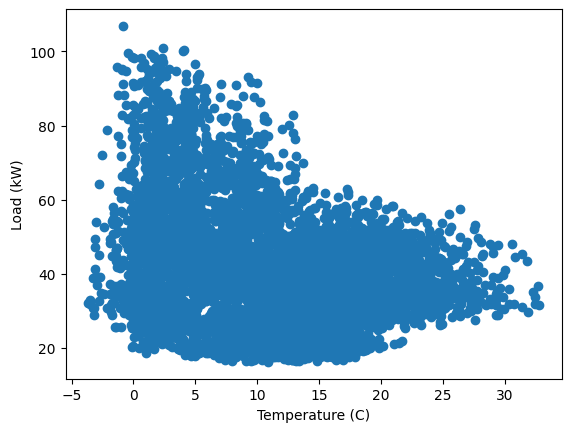

In [ ]:
fig = plt.figure()
axl = fig.add_subplot(111)
axl.scatter(weatherData.temperature[0:endTrainIndex].values, loadData.Load[0:endTrainIndex].values)
axl.set_ylabel('Load (kW)')
axl.set_xlabel('Temperature (C)');

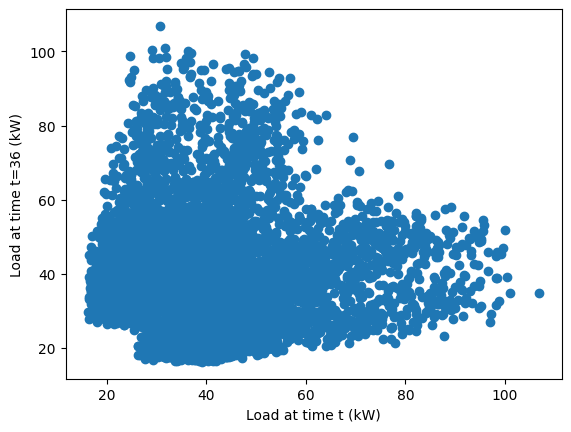

In [ ]:
loadArray = loadData.Load[0:endTrainIndex].values

fig = plt.figure()
axl = fig.add_subplot(111)
axl.scatter(loadArray[0:-36], loadArray[36:])
axl.set_ylabel('Load at time t=36 (kW)')
axl.set_xlabel('Load at time t (kW)');

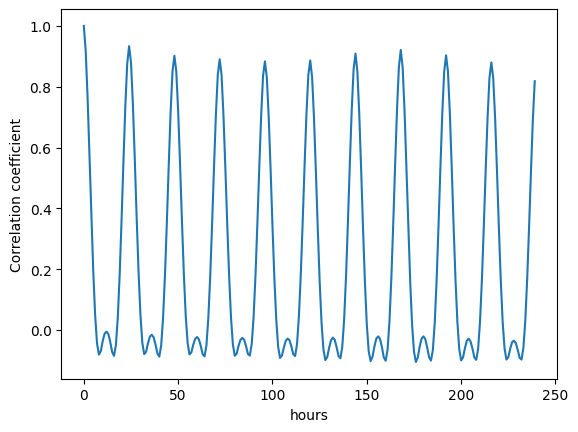

In [ ]:
loadSeries = loadData.Load[0:endTrainIndex]

fig = plt.figure()
axl = fig.add_subplot(111)

loadNorm = loadSeries - loadSeries.mean()
lagN = np.zeros((240))
for j in range(240):
    lagN[j]=loadNorm.autocorr(lag=j)

axl.plot(np.arange(0,240), lagN)
axl.set_ylabel('Correlation coefficient')
axl.set_xlabel('hours');


In [ ]:
lagN[48], lagN[168]

(0.9021594780624037, 0.9209467247114482)

## Basic MLR model

In our basic MLR model we will base our prediction of the load on:
* the load 24 hours previously
* the load 168 previously
* the forecasted temperature at the hour (*remember we assume the forecasted temperature is correct*)


Therefore, start with an initial model:
$ \hat{l}_{t} = \beta_{0} + \beta_{1,0}l_{t-24}\gamma_{0,t} + \beta_{1,1}l_{t-24}\gamma_{1,t} + \beta_{2} T_t $ <br>


* where $\gamma_(0,t)=1$ if day is Tues-Fri, and 0 otherwise
* where $\gamma_(1,t)=0$ if day is Tues-Fri, and 1 otherwise

$ \hat{l}_{t} = \beta_{0} + \sum_{i=0}^{i=1} \beta_{1,i}l_{t-24}\gamma_{i,t} + \beta_{2} T_t $ <br>


Model Two

$ \hat{l}_{t} = \beta_{0} + \beta_{1,0}l_{t-168}\gamma_{0,t} + \beta_{1,1}l_{t-168}\gamma_{1,t} + \beta_{2} T_t $ <br>


* where $\gamma_(0,t)=1$ if day is Tues-Fri, and 0 otherwise
* where $\gamma_(1,t)=0$ if day is Tues-Fri, and 1 otherwise

$ \hat{l}_{t} = \beta_{0} + \sum_{i=0}^{i=1} \beta_{1,i}l_{t-168}\gamma_{i,t} + \beta_{2} T_t $ <br>


Model Three


$ \hat{l}_{t} = \sum_{i=1}^{2} DoW_{i}[\beta_{0,i} + \beta_{1,i}l_{t-24} + \beta_{2,i}l_{t-168}] $ <br>



Model Four



$ \hat{l}_{t} = \sum_{i=1}^{2} ToD_{i}[\beta_{0,i} + \beta_{1,i}l_{t-24} + \beta_{2,i}l_{t-168}] $ <br>

Model Five

$ \hat{l}_{t} = \beta_{0} + \beta_{1,0}l_{t-168}\gamma_{0,t} + \beta_{1,1}l_{t-168}\theta_{0,t} + \beta_{2,0}l_{t-168}\gamma_{1,t} +\beta_{2,1}l_{t-168}\theta_{1,t} + \beta_{3}T_t + \beta_{2} T_t^2 $ <br>   

* where $\gamma_(0,t)=1$ if day is Mon-Fri, and 0 otherwise
* where $\gamma_(1,t)=0$ if day is Mon-Fri, and 1 otherwise

* where $\theta_(0,t)=1$ if time is between 0600 - 1700 HRS, and 0 otherwise
* where $\theta_(1,t)=0$ if time is between 1700 - 0600 HRS, and 1 otherwise




We have chosen to use data at a lag of 24 hours for training
So therefore our training actually starts after the first day

We make an array called features with the features we want to include:
* So column 1 is $l_{t-24}$
* So column 2 is $T_{t}$

Our target data is then the load at time $t$, i.e. $l_t$

### Create a features array which we will split into the training and testing data

In [ ]:
loadData.index[0], loadData.index[0].weekday()

(Timestamp('2013-01-01 01:00:00'), 1)

In [ ]:
DoW = loadData.index[24:endTestIndex].weekday


In [ ]:
ToD = loadData.index[24:endTestIndex].time


In [ ]:
ToD

array([datetime.time(1, 0), datetime.time(2, 0), datetime.time(3, 0), ...,
       datetime.time(22, 0), datetime.time(23, 0), datetime.time(0, 0)],
      dtype=object)

In [ ]:
DoW

Int64Index([2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
            ...
            3, 3, 3, 3, 3, 3, 3, 3, 3, 4],
           dtype='int64', name='time', length=7272)

In [ ]:
# Since we are using a 24 hour lagged variable - we cannot use the first 24 hours
#features = np.zeros((endTestIndex-24,3))

# 24 hour lagged load
#features[:,0] = loadData.Load[0:endTestIndex-24]
#features[:,1] = loadData.Load[0:endTestIndex-24]
# temperature at time t
#features[:,2] = temperatureData[24:endTestIndex]
#for j in range (endTestIndex-24):
 # if DoW[j] in [1,2,3,4]:
  #  features[j,0] = features[j,0]*1
   # features[j,1] = features[j,1]*0
 # else:
  #  features[j,0] = features[j,0]*0
  #  features[j,1] = features[j,1]*1


#yData = loadData.Load[24:endTestIndex].values


In [ ]:
yData

array([45.303, 35.82 , 29.559, ..., 58.377, 51.339, 38.472])

In [ ]:
## Since we are using a 168 hour lagged variable - we cannot use the first 168 hours
#features = np.zeros((endTestIndex-168,3))

# 24 hour lagged load
#features[:,0] = loadData.Load[0:endTestIndex-168]
#features[:,1] = loadData.Load[0:endTestIndex-168]
# temperature at time t
#features[:,2] = temperatureData[24:endTestIndex]
#for j in range (endTestIndex-168):
 # if DoW[j] in [1,2,3,4]:
  #  features[j,0] = features[j,0]*1
   # features[j,1] = features[j,1]*0
 # else:
  #  features[j,0] = features[j,0]*0
  #  features[j,1] = features[j,1]*1


#yData = loadData.Load[168:endTestIndex].values

In [ ]:
features[:,0]

array([47.097, 41.196, 32.764, ..., 58.955, 47.019, 39.3  ])

In [ ]:
#Third model
#features = np.zeros((endTestIndex-168,6))

# 24 hour lagged load
#features[:,0] = 1
#features[:,1] = loadData.Load[144:endTestIndex-24]
#features[:,2] = loadData.Load[0:endTestIndex-168]
#features[:,3] = 1
#features[:,4] = loadData.Load[144:endTestIndex-24]
#features[:,5] = loadData.Load[0:endTestIndex-168]

#for j in range (endTestIndex-168):
#  if DoW[j] in [1,2,3,4]:
#    features[j,0] = features[j,0]*1
#    features[j,1] = features[j,1]*0
 # else:
 #   features[j,0] = features[j,0]*0
 #   features[j,1] = features[j,1]*1


#yData = loadData.Load[168:endTestIndex].values


In [ ]:
#Fourth model
#features = np.zeros((endTestIndex-168,6))
#features[:,0] = 1
#features[:,1] = loadData.Load[144:endTestIndex-24]
#features[:,2] = loadData.Load[0:endTestIndex-168]

#features[:,3] = 1
#features[:,4] = loadData.Load[144:endTestIndex-24]
#features[:,5] = loadData.Load[0:endTestIndex-168]

#for j in range (endTestIndex-168):
 # if DoW[j] in [0,1,2,3,4]:
  #  features[j,0] = features[j,0]*1
   # features[j,1] = features[j,1]*0

  #else:
   # features[j,0] = features[j,0]*0
    #features[j,1] = features[j,1]*1

#for i in range (endTestIndex-168):
 #   if ToD[i] in [8,9,10,11,12,13,14,15,16,17]:
  #        features[i,0] = features[i,0]*1
   #       features[i,1] = features[i,1]*0

    #else:
     #     features[j,0] = features[j,0]*0
      #    features[j,1] = features[j,1]*1


#yData = loadData.Load[24:endTestIndex].values


In [ ]:
# Assigning 2D array loadData into first column of features
  # features = np.zeros((endTestIndex-168, 1))
    # Use .iloc for integer-location based indexing
  #  features[:, 0] = Comfortable.iloc[0:endTestIndex-168, 0].values



In [ ]:
features = np.zeros((endTestIndex1-24,2))
   # Use .iloc for integer-location based indexing
features[:, 0] = loadComfortable.iloc[0:endTestIndex1-24, 0].values
features[:,1] = temperatureData[24:endTestIndex]


yData1 = loadComfortable.iloc[24:endTestIndex, 0].values

In [ ]:
yData1

array([ 7.633,  5.369,  4.415, ..., 12.251,  9.757,  8.264])

In [ ]:
features = np.zeros((endTestIndex2-24,2))
   # Use .iloc for integer-location based indexing
features[:, 0] = loadAdversity.iloc[0:endTestIndex2-24, 0].values
features[:,1] = temperatureData[24:endTestIndex]


yData2 = loadAdversity.iloc[24:endTestIndex, 0].values

In [ ]:
yData2

array([21.686, 17.695, 13.491, ..., 16.086, 16.557, 14.846])

In [ ]:
features = np.zeros((endTestIndex3-24,2))
   # Use .iloc for integer-location based indexing
features[:, 0] = loadAffluent.iloc[0:endTestIndex3-24, 0].values
features[:,1] = temperatureData[24:endTestIndex]


yData3 = loadAffluent.iloc[24:endTestIndex, 0].values

In [ ]:
yData3

array([15.984, 12.756, 11.653, ..., 30.04 , 25.025, 15.362])

In [ ]:
features[:168, :]

array([[18.456,  3.98 ],
       [15.241,  3.68 ],
       [13.321,  3.58 ],
       [11.575,  3.17 ],
       [11.085,  3.46 ],
       [12.341,  3.37 ],
       [11.88 ,  3.07 ],
       [12.864,  4.28 ],
       [13.429,  4.86 ],
       [17.227,  5.57 ],
       [15.531,  6.07 ],
       [21.185,  6.77 ],
       [20.247,  7.28 ],
       [19.585,  7.88 ],
       [20.278,  7.98 ],
       [25.777,  7.98 ],
       [27.256,  8.27 ],
       [35.13 ,  8.77 ],
       [32.5  ,  9.48 ],
       [33.168, 10.07 ],
       [29.424, 10.27 ],
       [24.96 , 10.68 ],
       [26.925, 10.87 ],
       [21.458, 10.97 ],
       [15.984, 10.97 ],
       [12.756, 10.68 ],
       [11.653, 10.57 ],
       [10.9  , 10.48 ],
       [10.033, 10.48 ],
       [11.131, 10.17 ],
       [ 9.833,  9.77 ],
       [18.327,  9.67 ],
       [20.627,  9.97 ],
       [24.771, 10.27 ],
       [26.009, 10.48 ],
       [31.485, 10.78 ],
       [22.444, 11.08 ],
       [23.398, 11.67 ],
       [28.483, 11.78 ],
       [25.486, 11.47 ],


In [ ]:
# Now we can split the array features into training and testing
trainingFeatures = features[0:endTrainIndex-168,:]

trainingFeatures1 = features[0:endTrainIndex1-168,:]
trainingFeatures2 = features[0:endTrainIndex2-168,:]
trainingFeatures3 = features[0:endTrainIndex3-168,:]

testingFeatures = features[endTrainIndex-168:,:]

testingFeatures1 = features[endTrainIndex1-168:,:]
testingFeatures2 = features[endTrainIndex2-168:,:]
testingFeatures3 = features[endTrainIndex3-168:,:]

yDataTrain = yData[0:endTrainIndex-168]

yDataTrain1 = yData1[0:endTrainIndex1-168]
yDataTrain2= yData2[0:endTrainIndex2-168]
yDataTrain3 = yData3[0:endTrainIndex3-168]

yDataTest = yData[endTrainIndex-168:]

yDataTest1 = yData1[endTrainIndex1-168:]
yDataTest2 = yData2[endTrainIndex2-168:]
yDataTest3 = yData3[endTrainIndex3-168:]

So now we can fit our model. Notice that we don't need a column for $\beta_{0}$ as we specify the model to fit an intercept through the python package

In [ ]:
#MLR1 = linear_model.LinearRegression(fit_intercept=True)

MLR2 = linear_model.LinearRegression(fit_intercept=True)
MLR3 = linear_model.LinearRegression(fit_intercept=True)
MLR4 = linear_model.LinearRegression(fit_intercept=True)
# this first line initialises the model and specifies the options
# we only use fit intercept and keep the rest default

#MLR1.fit(trainingFeatures, yDataTrain)

MLR2.fit(trainingFeatures1, yDataTrain1)
MLR3.fit(trainingFeatures2, yDataTrain2)
MLR4.fit(trainingFeatures3, yDataTrain3)

# train the model

#coefMLR1 = MLR1.coef_
coefMLR2 = MLR2.coef_
coefMLR3 = MLR3.coef_
coefMLR4 = MLR4.coef_

OK now we can test the model!

In [ ]:
# this is the predicted load

#predictedMLR1 = MLR1.predict(testingFeatures)

predictedMLR2 = MLR2.predict(testingFeatures1)
predictedMLR3 = MLR3.predict(testingFeatures2)
predictedMLR4 = MLR4.predict(testingFeatures3)
# the actual load
# yDataTest

In [ ]:
# let's look at the data!
# look at the last two weeks of august and first two weeks of sept

#inspectLoad = loadData['Load'][startTestIndex-336:startTestIndex+336]
#MLR12weeksAug = MLR1.predict(trainingFeatures[-336:])

inspectComfortable = loadComfortable['Load'][startTestIndex1-336:startTestIndex1+336]
MLR12weeksAuga = MLR2.predict(trainingFeatures1[-336:])


inspectAdversity = loadAdversity['Load'][startTestIndex2-336:startTestIndex2+336]
MLR12weeksAugb = MLR3.predict(trainingFeatures2[-336:])


inspectAffluent = loadAffluent['Load'][startTestIndex3-336:startTestIndex3+336]
MLR12weeksAugc = MLR4.predict(trainingFeatures3[-336:])

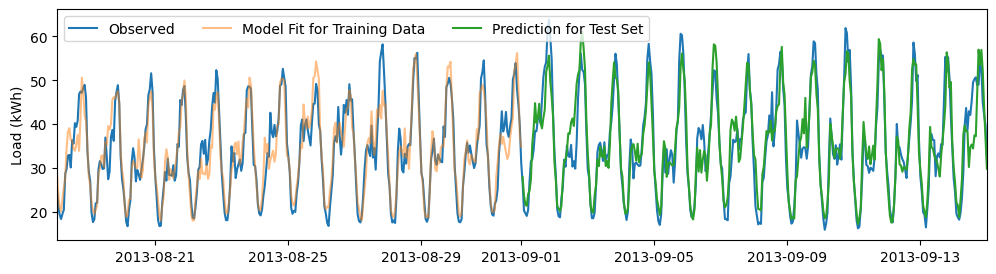

In [ ]:
# plotting a graph for the last two weeks of august and first two weeks september
#fig = plt.figure()
#fig.set_size_inches(12,3)
#ax1 = fig.add_subplot(111)
#ax1.plot(inspectLoad, label='Observed');
#ax1.plot(inspectLoad.index[0:336].to_numpy(), MLR12weeksAug, label='Model Fit for Training Data', alpha=0.5);
#ax1.plot(inspectLoad.index[336:].to_numpy(), predictedMLR1[0:336], label='Prediction for Test Set');
#ax1.set_xlim([inspectLoad.index[0],inspectLoad.index[-1]])
#plt.legend(loc='best', ncol=3);
#ax1.set_ylabel('Load (kWh)');

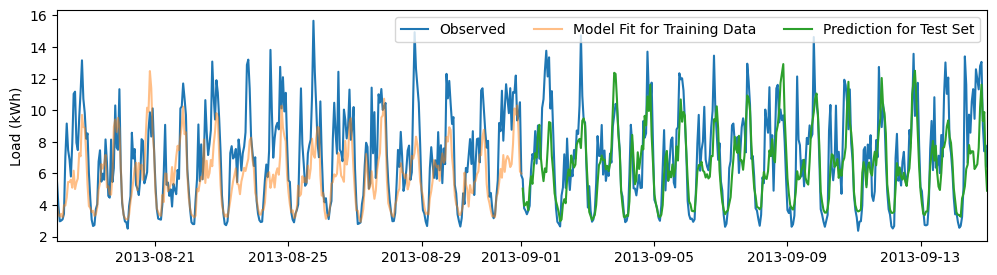

In [ ]:
# plotting a graph for the last two weeks of august and first two weeks september
fig = plt.figure()
fig.set_size_inches(12,3)
ax1 = fig.add_subplot(111)
ax1.plot(inspectComfortable, label='Observed');
ax1.plot(inspectComfortable.index[0:336].to_numpy(), MLR12weeksAuga, label='Model Fit for Training Data', alpha=0.5);
ax1.plot(inspectComfortable.index[336:].to_numpy(), predictedMLR2[0:336], label='Prediction for Test Set');
ax1.set_xlim([inspectComfortable.index[0],inspectComfortable.index[-1]])
plt.legend(loc='best', ncol=3);
ax1.set_ylabel('Load (kWh)');

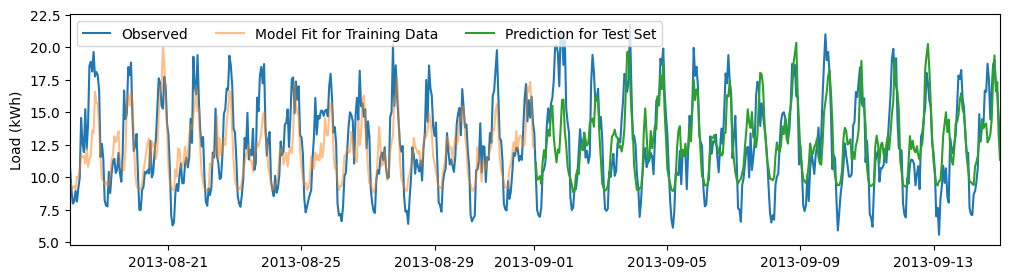

In [ ]:
# plotting a graph for the last two weeks of august and first two weeks september
fig = plt.figure()
fig.set_size_inches(12,3)
ax1 = fig.add_subplot(111)
ax1.plot(inspectAdversity, label='Observed');
ax1.plot(inspectAdversity.index[0:336].to_numpy(), MLR12weeksAugb, label='Model Fit for Training Data', alpha=0.5);
ax1.plot(inspectAdversity.index[336:].to_numpy(), predictedMLR3[0:336], label='Prediction for Test Set');
ax1.set_xlim([inspectAdversity.index[0],inspectAdversity.index[-1]])
plt.legend(loc='best', ncol=3);
ax1.set_ylabel('Load (kWh)');

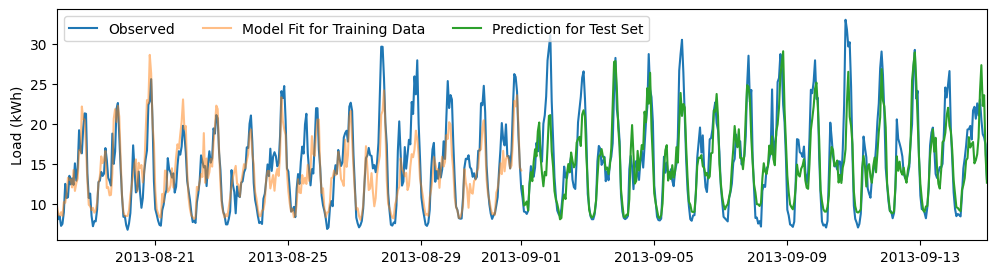

In [ ]:
# plotting a graph for the last two weeks of august and first two weeks september
fig = plt.figure()
fig.set_size_inches(12,3)
ax1 = fig.add_subplot(111)
ax1.plot(inspectAffluent, label='Observed');
ax1.plot(inspectAffluent.index[0:336].to_numpy(), MLR12weeksAugc, label='Model Fit for Training Data', alpha=0.5);
ax1.plot(inspectAffluent.index[336:].to_numpy(), predictedMLR4[0:336], label='Prediction for Test Set');
ax1.set_xlim([inspectAffluent.index[0],inspectAffluent.index[-1]])
plt.legend(loc='best', ncol=3);
ax1.set_ylabel('Load (kWh)');

We will use MAPEs as our error metric: $MAPE = \frac{100}{n}\sum_{t=t_1}^{t=t_n} |\frac{\hat{l}_t-l_t}{l_t}$|

In [ ]:
# Calculating MAPEs
MLR1TrainMAPE = 100*np.mean( np.abs((MLR1.predict(trainingFeatures)-yDataTrain)/yDataTrain) )
MLR1TestMAPE = 100*np.mean( np.abs((predictedMLR1-yDataTest)/yDataTest) )
print('The training MAPE is %.2f'%MLR1TrainMAPE)
print('The testing MAPE is %.2f'%MLR1TestMAPE)

In [ ]:
# Calculating MAPEs
MLR2TrainMAPE = 100*np.mean( np.abs((MLR2.predict(trainingFeatures1)-yDataTrain1)/yDataTrain1) )
MLR2TestMAPE = 100*np.mean( np.abs((predictedMLR2-yDataTest1)/yDataTest1) )
print('The training MAPE is %.2f'%MLR2TrainMAPE)
print('The testing MAPE is %.2f'%MLR2TestMAPE)

The training MAPE is 23.47
The testing MAPE is 21.00


### Now we implement the basic Neural Network

* the model is defined in keras
* Sequential model is defined with a layer-by-layer approach
* The NN is dense (as opposed to convolutional) - that is all the nodes are connected to all of the input nodes

We use the same features for training the Neural Net as the MLR:
* So column 1 is $l_{t-24}\gamma_{t,0}$
* So column 2 is $l_{t-24}\gamma_{t,1}$
* So column 3 is $T_{t}$

This is not a necessary step! You can use whatever inputs you would like to train the NN (ensuring to stay within the day-ahead constraint - assuming perfect foresight of temperatures)

In [ ]:
# create and fit Multilayer Perceptron model
NN1 = Sequential()
# first hidden layer, input_dim must equal the number of inputs
NN1.add(Dense(units=4, input_dim=3, activation='relu'))
# second hidden layer with 4 nodes
NN1.add(Dense(units=4, activation='relu'))
# output layer
NN1.add(Dense(units=1))
NN1.compile(loss='mean_squared_error', optimizer='adam')

In [ ]:
len(trainingFeatures)

5664

In [ ]:
NN1.fit(trainingFeatures, yDataTrain, epochs=40, batch_size=40, verbose=1)
# choosing verbose=1 will prinbt the output to the screen

Epoch 1/40
146/146 [==============================] - 0s 2ms/step - loss: 30.9225
Epoch 2/40
146/146 [==============================] - 0s 1ms/step - loss: 30.8126
Epoch 3/40
146/146 [==============================] - 0s 1ms/step - loss: 31.3310
Epoch 4/40
146/146 [==============================] - 0s 1ms/step - loss: 30.8480
Epoch 5/40
146/146 [==============================] - 0s 1ms/step - loss: 30.9751
Epoch 6/40
146/146 [==============================] - 0s 1ms/step - loss: 30.9972
Epoch 7/40
146/146 [==============================] - 0s 1ms/step - loss: 30.9624
Epoch 8/40
146/146 [==============================] - 0s 1ms/step - loss: 31.0044
Epoch 9/40
146/146 [==============================] - 0s 1ms/step - loss: 30.8811
Epoch 10/40
146/146 [==============================] - 0s 1ms/step - loss: 30.8771
Epoch 11/40
146/146 [==============================] - 0s 1ms/step - loss: 31.0445
Epoch 12/40
146/146 [==============================] - 0s 1ms/step - loss: 30.8919
Epoch 13/40
1

In [ ]:
# create arrays with the predictions for the training and testing set
trainingNN1 = NN1.predict(trainingFeatures)
testingNN1 = NN1.predict(testingFeatures)

46/46 [==============================] - 0s 884us/step


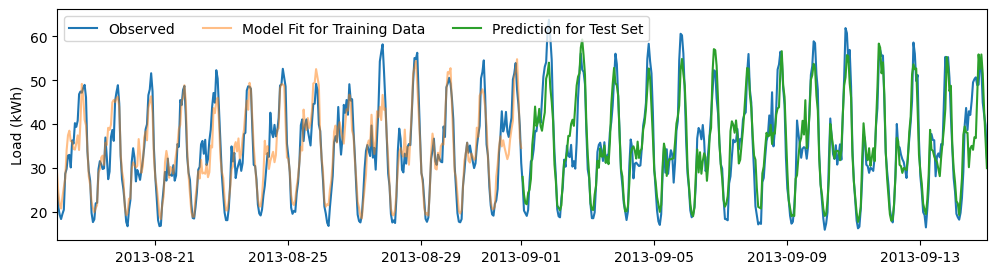

In [ ]:
# again let's look at the last two weeks in Aug and first two weeks in Sep
NN12weeksAug = trainingNN1[-336:]
NN12weeksSep = testingNN1[0:336]

fig = plt.figure()
fig.set_size_inches(12,3)
ax1 = fig.add_subplot(111)
ax1.plot(inspectLoad, label='Observed');
ax1.plot(inspectLoad.index[0:336].to_numpy(), NN12weeksAug, label='Model Fit for Training Data', alpha=0.5);
ax1.plot(inspectLoad.iloc[336:].index.to_numpy(), NN12weeksSep, label='Prediction for Test Set');
ax1.set_xlim([inspectLoad.index[0],inspectLoad.index[-1]])
plt.legend(loc='best', ncol=3);
ax1.set_ylabel('Load (kWh)');

In [ ]:
# Calculating MAPEs
NN1TrainMAPE = 100*np.mean( np.abs((trainingNN1[:,0]-yDataTrain)/yDataTrain) )
NN1TestMAPE = 100*np.mean( np.abs((testingNN1[:,0]-yDataTest)/yDataTest) )
print('The training MAPE is %.2f'%NN1TrainMAPE)
print('The testing MAPE is %.2f'%NN1TestMAPE)

The training MAPE is 10.23
The testing MAPE is 10.53


In [ ]:
ts[endTrainIndex]

Timestamp('2013-09-01 01:00:00')

Text(0, 0.5, 'Load (kW)')

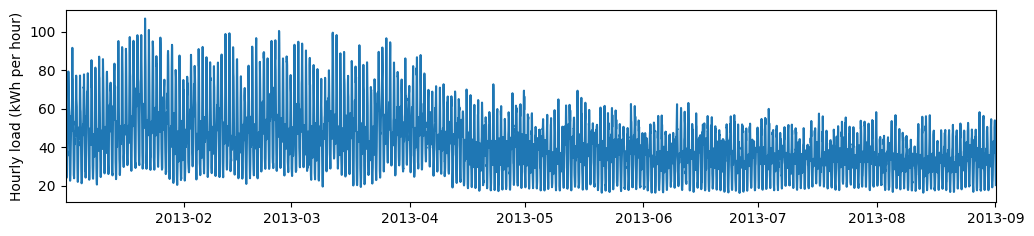

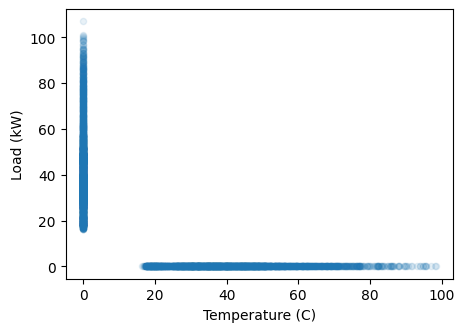

In [ ]:
fig = plt.figure(figsize=(12,2.5))
# add a subplot
ax1 = fig.add_subplot(1,1,1)
ax1.plot(ts, loadData)
ax1.set_xlim([ts[0], ts[endTrainIndex]])
ax1.set_ylabel('Hourly load (kWh per hour)')
# fig.savefig('HourlyLoad.png', dpi=200, format='png', bbox_inches='tight')

fig = plt.figure(figsize=(5,3.5))
ax1 = fig.add_subplot(111)
ax1.scatter(trainingFeatures[:,1],trainingFeatures[:,0],marker='o',s=20,alpha=0.1)
ax1.set_xlabel('Temperature (C)')
ax1.set_ylabel('Load (kW)')
# fig.savefig('ScatterExample.png', dpi=200, format='png', bbox_inches='tight')

In [ ]:
loadData

,Load
time,
2013-01-01 01:00:00,47.097
2013-01-01 02:00:00,41.196
2013-01-01 03:00:00,32.764
2013-01-01 04:00:00,25.882
2013-01-01 05:00:00,23.824
...,...
2013-12-31 20:00:00,78.483
2013-12-31 21:00:00,61.733
2013-12-31 22:00:00,61.803


(-0.2, 1.05)

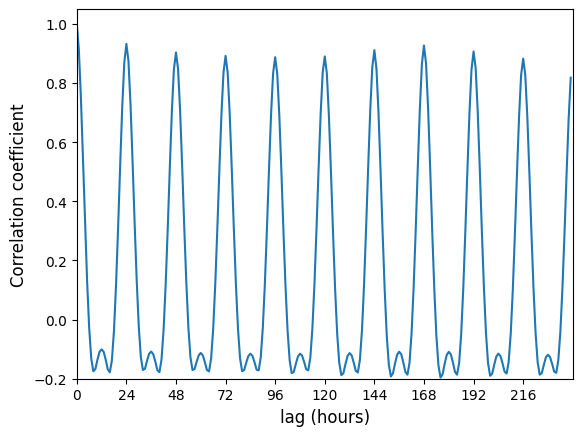

In [ ]:
# now lets look at autocorrelation of the load
loadNorm = loadData['Load']-loadData['Load'].mean()
nD = 10 # number of days
lagNWeeks = np.zeros((24*nD))
for j in range(len(lagNWeeks)):
    lagNWeeks[j] = loadNorm.autocorr(lag=j)

fig = plt.figure()
ax1 = fig.add_subplot(111)
l, = ax1.plot(np.arange(24*nD),lagNWeeks)

ax1.set_xlabel('lag (hours)', fontsize=12)
ax1.set_ylabel('Correlation coefficient', fontsize=12)
ax1.set_xlim([0,24*nD])
ax1.set_xticks(np.arange(0,24*nD,24));
ax1.set_ylim([-0.2,1.05])
# fig.savefig('AutoCorr.png', dpi=200, format='png', bbox_inches='tight')

### Some code for saving your NN model

In [ ]:
# # serialize model to JSON
# NN1_json = NN1.to_json()
# with open("NN1.json", "w") as json_file:
#     json_file.write(NN1_json)
# # serialize weights to HDF5
# NN1.save_weights("NN1.h5")
# print("Saved model to disk")

In [ ]:
# from keras.models import model_from_json
# # load json and create model
# json_file = open('NN1.json', 'r')
# loaded_model_json = json_file.read()
# json_file.close()
# loaded_model = model_from_json(loaded_model_json)
# # load weights into new model
# loaded_model.load_weights("NN1.h5")
# print("Loaded model from disk")

# # evaluate loaded model on test data
# loaded_model.compile(loss='mean_squared_error', optimizer='adam')


In [ ]:
# testingLoaded = loaded_model.predict(testingFeatures)

In [ ]:
# fig = plt.figure()
# fig.set_size_inches(12,3)
# ax1 = fig.add_subplot(111)
# ax1.plot(loadData['Load'][startTestIndex:endTestIndex], label='Observed');
# ax1.plot(loadData['Load'][startTestIndex:endTestIndex].index.to_numpy(), testingLoaded, label='Prediction for Test Set');
# plt.legend(loc='best', ncol=3);
# ax1.set_ylabel('Load (kWh)');